# Notebook : Entraînement d'un Transformer simple pour la prédiction du prochain token

In [69]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Utilisons les séquences générées par Agent13

In [70]:
Training_sequences = [
[[0, 1], [1, 1], [1, 3], [3, 1], [1, 4], [4, 1], [1, 7], [7, 1], [1, 8], [8, 0], [0, 2], [2, 0], [3, 3], [3, 4], [4, 3], [3, 7], [7, 3], [3, 8], [3, 10], [10, 1], [1, 10], [10, 2], [5, 1], [3, 5], [5, 3], [3, 6], [6, 1], [1, 5], [5, 5], [5, 6], [6, 3], [5, 8], [8, 1], [7, 4], [4, 4], [4, 7], [7, 7], [7, 8], [0, 3], [6, 5], [5, 10]],
[[0, 1, 1], [0, 1, 1], [1, 1, 3], [1, 1, 3], [1, 3, 1], [1, 3, 1], [3, 1, 4], [3, 1, 4], [1, 4, 1], [1, 4, 1], [4, 1, 7], [4, 1, 7], [1, 7, 1], [1, 7, 1], [7, 1, 8], [7, 1, 8], [1, 8, 0], [1, 8, 0], [8, 0, 2], [8, 0, 2], [0, 2, 0], [0, 2, 0], [2, 0, 3], [3, 3, 4], [3, 3, 4], [3, 4, 3], [3, 4, 3], [4, 3, 7], [4, 3, 7], [3, 7, 3], [3, 7, 3], [7, 3, 8], [7, 3, 8], [3, 10, 1], [3, 10, 1], [10, 1, 10], [10, 1, 10], [1, 10, 2], [1, 10, 2], [5, 1, 3], [5, 1, 3], [1, 3, 3], [1, 3, 3], [3, 3, 5], [3, 3, 5], [3, 5, 3], [3, 5, 3], [5, 3, 6], [5, 3, 6], [3, 6, 1], [3, 6, 1], [6, 1, 5], [6, 1, 5], [1, 5, 5], [1, 5, 5], [5, 5, 6], [5, 5, 6], [5, 6, 3], [5, 6, 3], [6, 3, 3], [6, 3, 3], [3, 5, 8], [3, 5, 8], [5, 8, 1], [5, 8, 1], [8, 1, 7], [8, 1, 7], [1, 7, 4], [1, 7, 4], [7, 4, 4], [7, 4, 4], [4, 4, 7], [4, 4, 7], [4, 7, 7], [4, 7, 7], [7, 7, 8], [7, 7, 8], [8, 0, 3], [6, 5, 10], [6, 5, 10], [2, 0, 3]],
[[0, 1, 1, 3], [1, 1, 3, 1], [1, 3, 1, 4], [3, 1, 4, 1], [1, 4, 1, 7], [4, 1, 7, 1], [1, 7, 1, 8], [7, 1, 8, 0], [1, 8, 0, 2], [8, 0, 2, 0], [2, 0, 2, 0], [2, 0, 2, 0], [0, 2, 0, 3], [0, 2, 0, 3], [2, 0, 3, 3], [2, 0, 3, 3], [3, 3, 4, 3], [3, 4, 3, 7], [4, 3, 7, 3], [3, 7, 3, 8], [3, 8, 0, 2], [3, 8, 0, 2], [3, 10, 1, 10], [10, 1, 10, 2], [2, 0, 3, 5], [5, 1, 3, 3], [1, 3, 3, 5], [3, 3, 5, 3], [3, 5, 3, 6], [5, 3, 6, 1], [3, 6, 1, 5], [6, 1, 5, 5], [1, 5, 5, 6], [5, 5, 6, 3], [5, 6, 3, 3], [6, 3, 3, 5], [3, 3, 5, 8], [3, 5, 8, 1], [5, 8, 1, 7], [8, 1, 7, 4], [1, 7, 4, 4], [7, 4, 4, 7], [4, 4, 7, 7], [4, 7, 7, 8], [0, 2, 0, 3], [7, 8, 0, 3], [10, 2, 0, 3], [0, 2, 0, 2]],
[[0, 2, 0, 2, 0], [2, 0, 2, 0, 3], [0, 2, 0, 3, 3], [2, 0, 3, 3, 4], [7, 3, 8, 0, 2], [0, 2, 0, 3, 10], [0, 2, 0, 3, 10], [10, 2, 0, 2, 0], [10, 2, 0, 2, 0], [2, 0, 3, 5, 1], [2, 0, 3, 5, 1], [8, 0, 2, 0, 3], [7, 8, 0, 3, 6], [5, 10, 2, 0, 3], [5, 10, 2, 0, 3], [8, 0, 2, 0, 2]],
[[8, 0, 2, 0, 2, 0], [8, 0, 2, 0, 2, 0], [0, 2, 0, 2, 0, 3], [0, 2, 0, 2, 0, 3], [0, 2, 0, 3, 10, 1], [1, 10, 2, 0, 2, 0], [0, 2, 0, 2, 0, 3], [2, 0, 3, 5, 1, 3], [7, 8, 0, 2, 0, 3], [7, 8, 0, 3, 6, 5], [7, 8, 0, 3, 6, 5], [6, 5, 10, 2, 0, 3], [7, 8, 0, 2, 0, 2]]
]

In [71]:
class TokenDataset(Dataset):
    def __init__(self, sequences, max_length=10):
        self.sequences = sequences
        self.max_length = max_length
        
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        input_seq = seq[:-1]
        target_seq = seq[1:]
        # input_seq = input_seq + [0] * (self.max_length - len(input_seq))  # OG: pas de padding
        # target_seq = target_seq + [0] * (self.max_length - len(target_seq))
        return torch.tensor(input_seq), torch.tensor(target_seq)

def create_dataloader(sequences, batch_size=2, max_length=10):
    dataset = TokenDataset(sequences, max_length=max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


# Créons le modèle

In [72]:

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size=12, d_model=32, nhead=4, num_layers=2, max_length=10):
        super(SimpleTransformer, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_length, d_model)
        # encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.max_length = max_length

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_emb(x) + self.pos_emb(positions)
        # x = x.permute(1, 0, 2)
        # out = self.transformer_encoder(x)
        # out = out.permute(1, 0, 2)
        out = self.transformer_encoder(x)
        logits = self.fc_out(out)
        return logits


In [73]:

def predict_next_token_probs(model, input_sequence, max_length=10, device='cpu'):
    model.eval()
    if len(input_sequence) > max_length:
        raise ValueError(f"Input sequence length {len(input_sequence)} exceeds maximum {max_length}")
    input_seq = input_sequence # + [0] * (max_length - len(input_sequence))  OG no padding
    input_tensor = torch.tensor(input_seq, device=device).unsqueeze(0)
    with torch.no_grad():
        logits = model(input_tensor)
    return logits
    last_index = len(input_sequence) - 1
    logits_for_next_token = logits[0, last_index, :]
    # Pairwise probabilities
    pairwise_logits = logits[0, -1, :].reshape(-1, 2)
    probabilities = nn.functional.softmax(pairwise_logits, dim=1).flatten().tolist()
    return probabilities
    # probs = F.softmax(logits_for_next_token, dim=0)
    # return probs


In [82]:

def train_model(model, dataloader, num_epochs=10, learning_rate=1e-3, device='cpu'):
    model.train()
    # criterion = nn.CrossEntropyLoss(ignore_index=0)  OG no padding
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_tokens = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # Calcul de l'accuracy
            preds = outputs.argmax(dim=1)
            # mask = targets != 0  # on ignore les tokens de padding # OG pas de padding
            correct = (preds == targets) # & mask
            total_correct += correct.sum().item()
            total_tokens += targets.numel()  # .sum().item() # OG pas de padding
        avg_loss = total_loss / len(dataloader)
        # print(f"Époque [{epoch+1}/{num_epochs}], Perte moyenne : {avg_loss:.4f}")
        accuracy = total_correct / total_tokens if total_tokens > 0 else 0.0
        print(f"Époque [{epoch+1}/{num_epochs}], Perte moyenne : {avg_loss:.2f}, Accuracy : {accuracy:.2f} = {total_correct}/{total_tokens}")

# Instancions le modèle

In [83]:
torch.manual_seed(42)
max_length = 6
d_model = 16  # Dimension de l'embedding. Résultats visiblement moins bons en dessous de 16
nhead = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleTransformer(vocab_size=12, d_model=d_model, nhead=nhead, max_length=max_length).to(device)

In [84]:
for example_sequences in Training_sequences:
    print(example_sequences)
    dataloader = create_dataloader(example_sequences, batch_size=16, max_length=max_length)
    train_model(model, dataloader, num_epochs=20, learning_rate=1e-3, device=device)

[[0, 1], [1, 1], [1, 3], [3, 1], [1, 4], [4, 1], [1, 7], [7, 1], [1, 8], [8, 0], [0, 2], [2, 0], [3, 3], [3, 4], [4, 3], [3, 7], [7, 3], [3, 8], [3, 10], [10, 1], [1, 10], [10, 2], [5, 1], [3, 5], [5, 3], [3, 6], [6, 1], [1, 5], [5, 5], [5, 6], [6, 3], [5, 8], [8, 1], [7, 4], [4, 4], [4, 7], [7, 7], [7, 8], [0, 3], [6, 5], [5, 10]]
Époque [1/20], Perte moyenne : 2.77, Accuracy : 0.12 = 5/41
Époque [2/20], Perte moyenne : 2.40, Accuracy : 0.12 = 5/41
Époque [3/20], Perte moyenne : 2.24, Accuracy : 0.12 = 5/41
Époque [4/20], Perte moyenne : 2.25, Accuracy : 0.24 = 10/41
Époque [5/20], Perte moyenne : 2.22, Accuracy : 0.22 = 9/41
Époque [6/20], Perte moyenne : 2.27, Accuracy : 0.17 = 7/41
Époque [7/20], Perte moyenne : 2.19, Accuracy : 0.22 = 9/41
Époque [8/20], Perte moyenne : 2.18, Accuracy : 0.22 = 9/41
Époque [9/20], Perte moyenne : 2.19, Accuracy : 0.20 = 8/41
Époque [10/20], Perte moyenne : 2.09, Accuracy : 0.24 = 10/41
Époque [11/20], Perte moyenne : 2.11, Accuracy : 0.15 = 6/41
Ép

# Prédiction

In [77]:
import pandas as pd

input_sequence = [2]  # Expect next token 0
logits = predict_next_token_probs(model, input_sequence, max_length=max_length, device=device)

last_index = len(input_sequence) - 1
logits_for_next_token = logits[0, last_index, :]
probs = F.softmax(logits_for_next_token, dim=0)

# probs est un tenseur 1D de taille (vocab_size,)
most_probable_token = torch.argmax(probs).item()
print(f"Predicted token: {most_probable_token}")

# Pairwise probabilities
pairwise_logits = logits_for_next_token.reshape(-1, 2)
outcome_probs = nn.functional.softmax(pairwise_logits, dim=1).flatten().tolist()

# Visualize the dataframe
expected_df = pd.DataFrame({
    'token':  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'action': [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
    'outcome':[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    'valence':[5, -10, -1, -1, -1, -1, -1, -1, -3, -3, -3, -3],
    'probability': probs, 
    'outcome_probs': outcome_probs})
expected_df

Predicted token: 0


,token,action,outcome,valence,probability,outcome_probs
0,0,0,0,5,0.918104,0.994446
1,1,0,1,-10,0.005128,0.005554
2,2,1,0,-1,0.015539,0.812600
3,3,1,1,-1,0.003584,0.187400
4,4,2,0,-1,0.001403,0.097986
5,5,2,1,-1,0.012920,0.902014
6,6,3,0,-1,0.012563,0.744572
7,7,3,1,-1,0.004310,0.255428
8,8,4,0,-3,0.007862,0.687755
9,9,4,1,-3,0.003569,0.312245


# On visualise l'embedding

La fonction de visualisation en 3D

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

# Liste de formes de marqueurs disponibles dans Plotly
marker_symbols = ['diamond', 'diamond', 'square', 'square', 'square', 'square','square', 'square', 'circle', 'cross', 'circle', 'cross']
# Couleurs (différentes pour chaque token)
marker_colors = ['#D6D6D6', '#F93943', '#FAE2DB', '#535865', '#FAE2DB', '#535865', '#FAE2DB', '#535865', '#D6D6D6', '#D6D6D6', '#D6D6D6', '#D6D6D6']

labels = ['forward', 'bump', 'front_empty', 'front_wall', 'left_empty', 'left_wall','right_empty', 'right_wall', 'turn_left', 'turn_left', 'turn_right', 'turn_righ']
tags = ['forward', 'bump', 'front', 'front', 'left', 'left','right', 'right', 'left', '', 'right', '']

def plotly_embedding(embedding_weights):
    # Extraire les vecteurs d'embedding
    # embedding_weights = agent._lstm.embedding.weight.data        
    # Récupérer les coordonnées
    x = embedding_weights[:, 0].detach().numpy()
    y = embedding_weights[:, 1].detach().numpy()
    z = embedding_weights[:, 2].detach().numpy()
    #labels = [f"Token {i}" for i in range(agent._lstm.len_vocab)]
    # Créer une figure Plotly
    fig = go.Figure()
    
    for i in range(12):
        # Exclude the turn wall interactions
        if i in [9, 11]:
            continue
        fig.add_trace(go.Scatter3d(
            x=[x[i]],
            y=[y[i]],
            z=[z[i]],
            mode='markers+text',
            name=labels[i],
            marker=dict(
                size=10,
                color=marker_colors[i],
                symbol=marker_symbols[i],
                line=dict(width=1, color='black')
            ),
            text= tags[i],
            textposition='top center'
        ))    
    fig.update_layout(
        # title='Visualisation 3D des embeddings',
        width=900,
        height=700,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )  
    # Affichage interactif
    fig.show(config={"toImageButtonOptions": {"format": "svg"}}) # Spécifie le format de sauvegarde associé au bouton "download" 

Différents essais de projection depuis l'espace d'embedding à 16 dimensions vers un espace à 3 dimensions.

In [10]:
# Projection dans une direction aléatoire

def project_token_embeddings_to_3D(model):
    """
    Renvoie un tenseur (vocab_size, 3) correspondant aux embeddings de tokens projetés dans ℝ³.
    """
    # Récupère la matrice d'embedding des tokens (vocab_size, d_model)
    token_embeddings = model.token_emb.weight.data  # (vocab_size, d_model)

    # Projection linéaire vers 3 dimensions
    projector = nn.Linear(token_embeddings.size(1), 3, bias=False)  # d_model → 3

    projected = projector(token_embeddings)  # (vocab_size, 3)
    return projected


In [36]:
# Projection sur les composantes principales

from sklearn.decomposition import PCA
import torch

def project_token_embeddings_to_3D(model):
    """
    Projects token embeddings from the model into a 3D space using PCA.

    Args:
        model (nn.Module): The model containing token embeddings.

    Returns:
        Tensor of shape (vocab_size, 3): The 3D coordinates of each token.
    """
    # Extract the embedding weights
    token_embeddings = model.token_emb.weight.detach().cpu().numpy()

    # Apply PCA to reduce to 3 dimensions
    pca = PCA(n_components=3)
    projected = pca.fit_transform(token_embeddings)

    # Return as a PyTorch tensor
    return torch.tensor(projected)


In [34]:
# Projection TSNE

from sklearn.manifold import TSNE
def project_token_embeddings_to_3D(model):
    """
    Projette les embeddings des tokens du modèle dans un espace 3D à l'aide de t-SNE.

    Args:
        model (nn.Module): Le modèle contenant l'embedding des tokens.

    Returns:
        Tensor (vocab_size, 3) : les coordonnées 3D de chaque token.
    """
    # Extraire les poids d'embedding
    token_embeddings = model.token_emb.weight.detach().cpu().numpy()

    # Appliquer t-SNE pour projeter en 3D
    tsne = TSNE(n_components=3, perplexity=5, learning_rate=200, init='random', random_state=42)
    projected = tsne.fit_transform(token_embeddings)

    # Convertir en tenseur PyTorch pour compatibilité avec le reste
    return torch.tensor(projected)


In [81]:
# Projection par la methode des Feature Agglomeration

group_axes = {
    # "direction_forward": [0, 1, 2, 3],      # Tokens : forward, front_empty, front_wall
    # "direction_left": [4, 5, 8],      # left_empty, left_wall, turn_left, turn_left (duplicated)
    # "direction_right": [6, 7, 10],   # right_empty, right_wall, turn_right, turn_right
    "move": [0, 8, 10],             # forward, turn_left, turn_right
    "feel_wall": [3, 5, 7],         # bump, front_wall, left_wall, right_wall
    "feel_empty": [2, 4, 6],
}

def project_token_embeddings_to_3D(model):
    """
    Renvoie un tenseur (vocab_size, 3) correspondant aux embeddings de tokens projetés dans ℝ³.
    """
    projections = []
    for group in group_axes.values():
        group_embedding = model.token_emb.weight[group].mean(dim=0)
        projections.append(group_embedding)
    projection_matrix = torch.stack(projections)  # shape (n_axes, d_model)

    projected = torch.matmul(model.token_emb.weight, projection_matrix.T) 

    return projected


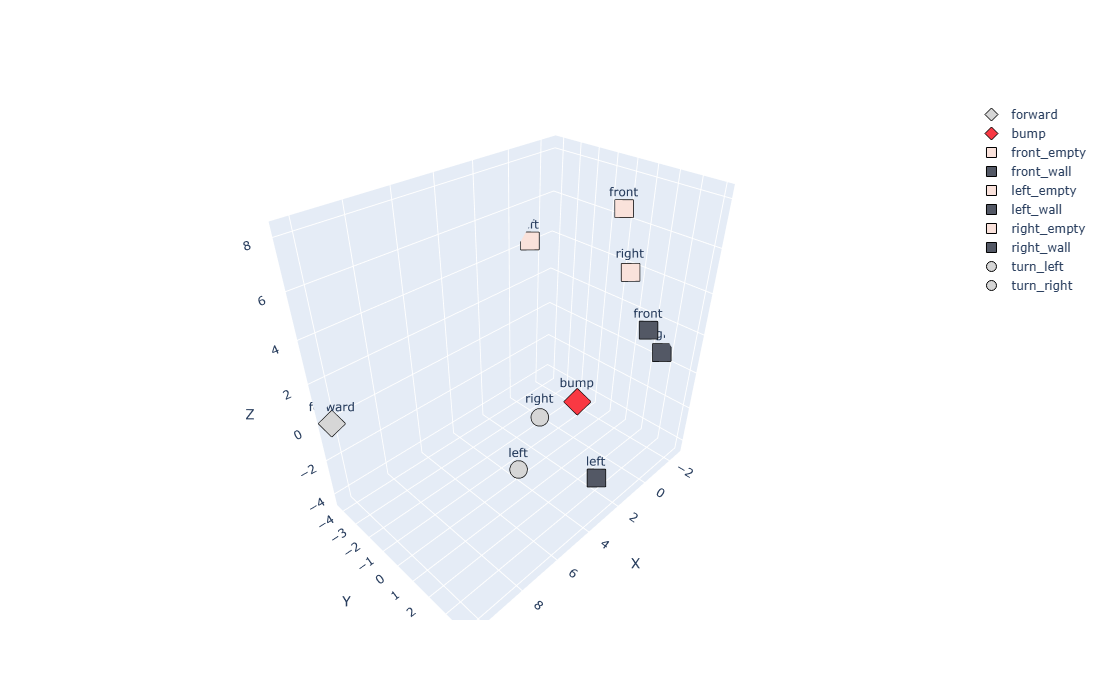

In [86]:
projected = project_token_embeddings_to_3D(model)
plotly_embedding(projected)

Sous certains angles de projection, on voit des regroupements intéressants des tokens, par example dans la Figure 1.

![embedding](6-embedding.svg)

_Figure 1: Projection de l'embedding: Les interactions "feel_empty" sont regroupées en haut à droite, les interactions "feel wall" et "bump" en bas à droite, et les interactions de déplacement à gauche ("forward" et "turn")._